In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator


url_fr = "https://disease.sh/v3/covid-19/historical/France?lastdays=all"
url_it = "https://disease.sh/v3/covid-19/historical/Italy?lastdays=all"

resp_fr = requests.get(url_fr)
resp_it = requests.get(url_it)

resp_fr.raise_for_status()
resp_it.raise_for_status()

data_fr_js = resp_fr.json()
data_it_js = resp_it.json()

data_it = pd.DataFrame(data_it_js["timeline"])
data_fr = pd.DataFrame(data_fr_js["timeline"])

print(data_it.describe()) 
print(data_fr.describe())

              cases         deaths     recovered
count  1.143000e+03    1143.000000  1.143000e+03
mean   8.821664e+06  111930.694663  6.642502e+05
std    9.064593e+06   59672.484414  1.257262e+06
min    0.000000e+00       0.000000  0.000000e+00
25%    7.457085e+05   39235.500000  0.000000e+00
50%    4.440669e+06  128432.000000  0.000000e+00
75%    1.736443e+07  166509.000000  2.606320e+05
max    2.560351e+07  188322.000000  4.144608e+06
              cases         deaths      recovered
count  1.143000e+03    1143.000000    1143.000000
mean   1.409091e+07   99221.659668   84432.664917
std    1.470445e+07   53297.832483  128282.286212
min    0.000000e+00       0.000000       0.000000
25%    1.579906e+06   38108.500000       0.000000
50%    6.543481e+06  112925.000000       0.000000
75%    2.964361e+07  149168.000000  113149.000000
max    3.986672e+07  166176.000000  415111.000000


In [3]:
print(data_fr.isnull().values.any()) 
print(data_it.isnull().values.any()) 

False
False


In [4]:
print(data_it.index.duplicated().sum())
print(data_fr.index.duplicated().sum())
#stampa il numero di volte in cui una data è ripetuta

0
0


By performing a general analysis of the dataset using the describe command, we encountered an issue. Specifically, for the "recovered" variable in both France and Italy, the median is significantly different from the mean. In particular, the value of zero for a cumulative variable—such as the number of recovered individuals—does not make logical sense. Further investigation of the dataset revealed the presence of null values. After 08/05/2021, the recovered data for both countries consist only of zeros.

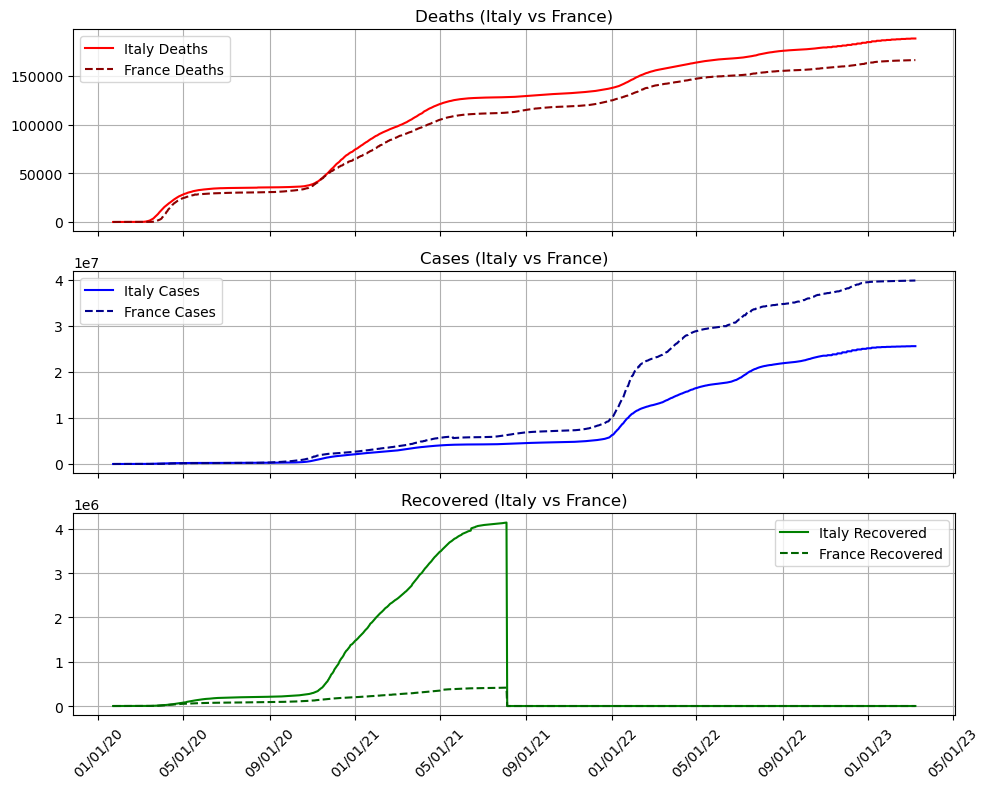

In [6]:
data_fr.index = pd.to_datetime(data_fr.index, format="%m/%d/%y")
data_it.index = pd.to_datetime(data_it.index, format="%m/%d/%y")

# Creare il grafico per i dati di Italia e Francia
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Formattazione dell'asse x
date_locator = AutoDateLocator()
date_formatter = DateFormatter("%m/%d/%y")

# Dati di decessi (Italia vs Francia)
axes[0].plot(data_it.index, data_it["deaths"], label="Italy Deaths", color="red")
axes[0].plot(data_fr.index, data_fr["deaths"], label="France Deaths", color="darkred", linestyle="dashed")
axes[0].set_title("Deaths (Italy vs France)")
axes[0].legend()

# Dati di casi (Italia vs Francia)
axes[1].plot(data_it.index, data_it["cases"], label="Italy Cases", color="blue")
axes[1].plot(data_fr.index, data_fr["cases"], label="France Cases", color="darkblue", linestyle="dashed")
axes[1].set_title("Cases (Italy vs France)")
axes[1].legend()

# Dati di guarigioni (Italia vs Francia)
axes[2].plot(data_it.index, data_it["recovered"], label="Italy Recovered", color="green")
axes[2].plot(data_fr.index, data_fr["recovered"], label="France Recovered", color="darkgreen", linestyle="dashed")
axes[2].set_title("Recovered (Italy vs France)")
axes[2].legend()

# Configurare l'asse x per tutti i subplot
for ax in axes:
    ax.xaxis.set_major_locator(date_locator)
    ax.xaxis.set_major_formatter(date_formatter)
    ax.grid(True)

plt.xticks(rotation=45)  # Ruota le etichette dell'asse x per renderle leggibili
plt.tight_layout()
plt.show()

In [7]:
zero_recovered_it = data_it[(data_it["recovered"] == 0) & (data_it.index > "31-05-2021")].index.min()
zero_recovered_fr = data_fr[(data_it["recovered"] == 0) & (data_fr.index > "31-05-2021")].index.min()

print(zero_recovered_it)
print(zero_recovered_fr)

2021-08-05 00:00:00
2021-08-05 00:00:00


Let's focus on analyzing the values up to 08/05/2021.

In [9]:
cutoff_date = "7/5/21"
data_fr_cut = data_fr[data_fr.index <= cutoff_date]
data_it_cut = data_it[data_it.index <= cutoff_date]

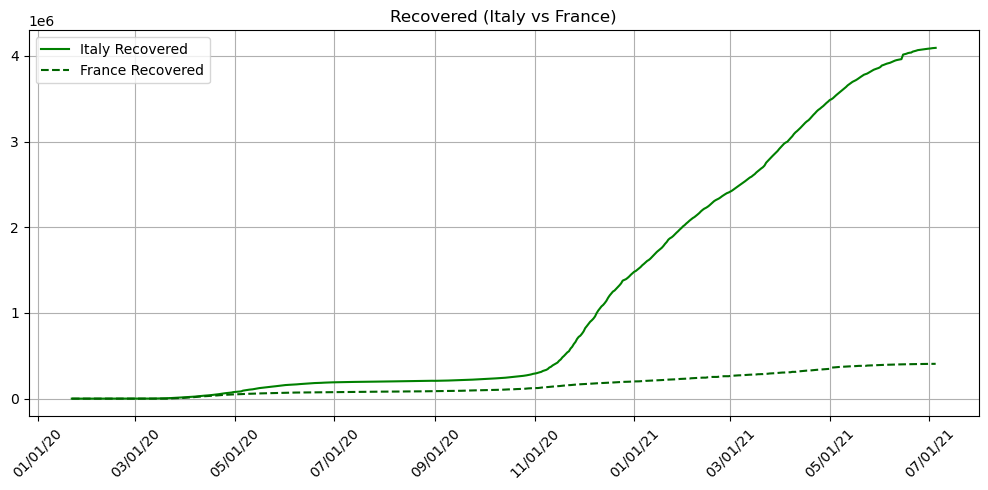

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(data_it_cut.index, data_it_cut["recovered"], label="Italy Recovered", color="green")
ax.plot(data_fr_cut.index, data_fr_cut["recovered"], label="France Recovered", color="darkgreen", linestyle="dashed")
ax.set_title("Recovered (Italy vs France)")
ax.legend()

# Configurare l'asse x
ax.xaxis.set_major_locator(date_locator)
ax.xaxis.set_major_formatter(date_formatter)
ax.grid(True)

plt.xticks(rotation=45)  # Ruota le etichette dell'asse x per renderle leggibili
plt.tight_layout()
plt.show()

The three variables used above are cumulative. We use the `.diff` command to observe the daily trend of the values.

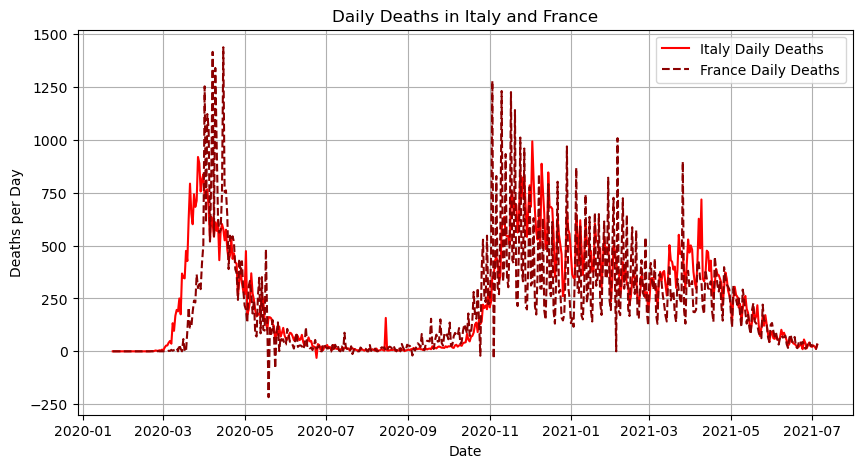

In [12]:
data_it_cut = data_it_cut.copy()
data_fr_cut = data_fr_cut.copy()
data_it_cut["daily_deaths"] = data_it_cut["deaths"].diff()
data_fr_cut["daily_deaths"] = data_fr_cut["deaths"].diff()

plt.figure(figsize=(10, 5))
plt.plot(data_it_cut.index, data_it_cut["daily_deaths"], label="Italy Daily Deaths", color="red")
plt.plot(data_fr_cut.index, data_fr_cut["daily_deaths"], label="France Daily Deaths", color="darkred", linestyle="dashed")

plt.title("Daily Deaths in Italy and France")
plt.xlabel("Date")
plt.ylabel("Deaths per Day")
plt.legend()
plt.grid()
plt.show()

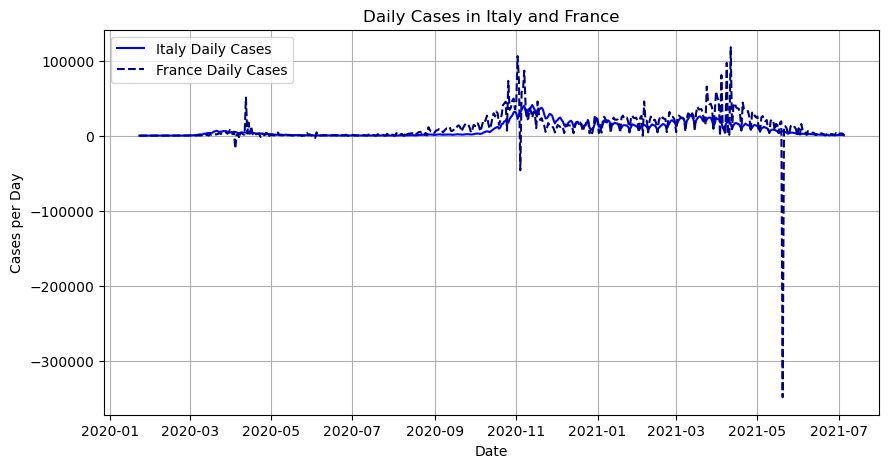

In [13]:
data_it_cut = data_it_cut.copy()
data_fr_cut = data_fr_cut.copy()
data_it_cut["daily_cases"] = data_it_cut["cases"].diff()
data_fr_cut["daily_cases"] = data_fr_cut["cases"].diff()

plt.figure(figsize=(10, 5))
plt.plot(data_it_cut.index, data_it_cut["daily_cases"], label="Italy Daily Cases", color="blue")
plt.plot(data_fr_cut.index, data_fr_cut["daily_cases"], label="France Daily Cases", color="darkblue", linestyle="dashed")

plt.title("Daily Cases in Italy and France")
plt.xlabel("Date")
plt.ylabel("Cases per Day")
plt.legend()
plt.grid()
plt.show()

WTF NON è CUMULATIVA???P

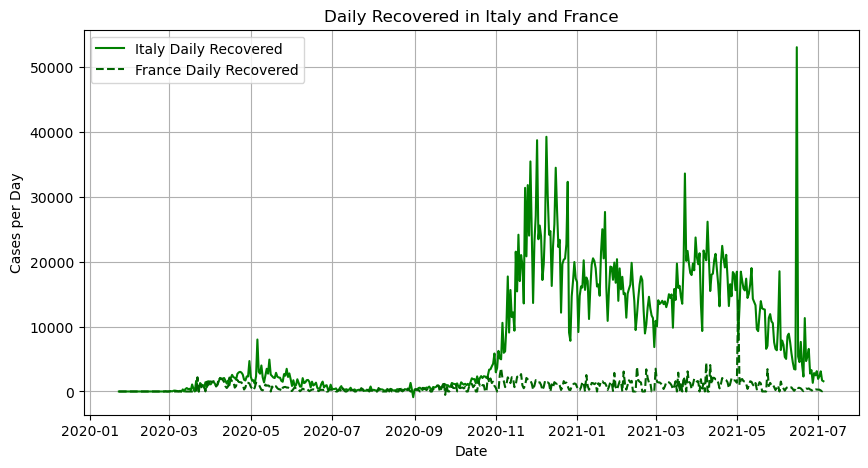

In [15]:
data_it_cut = data_it_cut.copy()
data_it_cut["daily_recovered"] = data_it_cut["recovered"].diff()
data_fr_cut = data_fr_cut.copy()
data_fr_cut["daily_recovered"] = data_fr_cut["recovered"].diff()

plt.figure(figsize=(10, 5))
plt.plot(data_it_cut.index, data_it_cut["daily_recovered"], label="Italy Daily Recovered", color="green")
plt.plot(data_fr_cut.index, data_fr_cut["daily_recovered"], label="France Daily Recovered", color="darkgreen", linestyle="dashed")

plt.title("Daily Recovered in Italy and France")
plt.xlabel("Date")
plt.ylabel("Cases per Day")
plt.legend()
plt.grid()
plt.show()

Let's now focus on analyzing the weekly data.

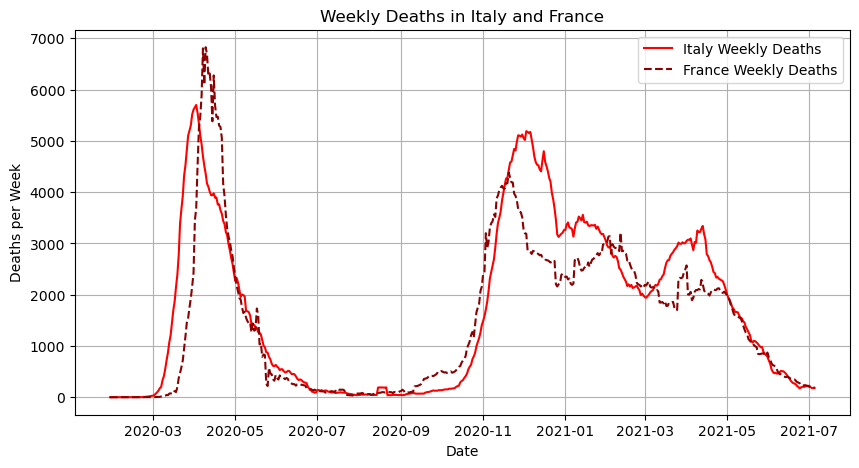

In [25]:
data_it_cut = data_it_cut.copy()
data_it_cut.loc[:, "weekly_deaths"] = data_it_cut["deaths"].diff(periods=7)
data_fr_cut = data_fr_cut.copy()
data_fr_cut.loc[:, "weekly_deaths"] = data_fr_cut["deaths"].diff(periods=7)

plt.figure(figsize=(10, 5))
plt.plot(data_it_cut.index, data_it_cut["weekly_deaths"], label="Italy Weekly Deaths", color="red")
plt.plot(data_fr_cut.index, data_fr_cut["weekly_deaths"], label="France Weekly Deaths", color="darkred", linestyle="dashed")

plt.title("Weekly Deaths in Italy and France")
plt.xlabel("Date")
plt.ylabel("Deaths per Week")
plt.legend()
plt.grid()
plt.show()


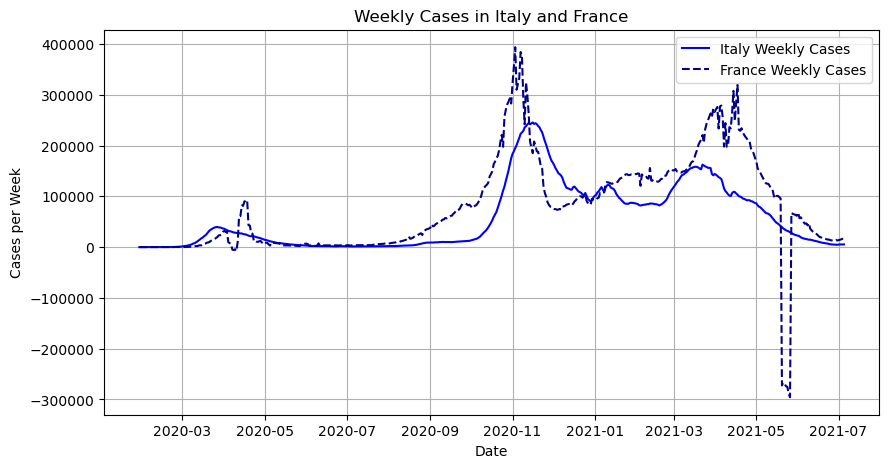

In [33]:
data_it_cut = data_it_cut.copy()
data_fr_cut = data_fr_cut.copy()
data_it_cut["weekly_cases"] = data_it_cut["cases"].diff(periods=7)
data_fr_cut["weekly_cases"] = data_fr_cut["cases"].diff(periods=7)

plt.figure(figsize=(10, 5))
plt.plot(data_it_cut.index, data_it_cut["weekly_cases"], label="Italy Weekly Cases", color="blue")
plt.plot(data_fr_cut.index, data_fr_cut["weekly_cases"], label="France Weekly Cases", color="darkblue", linestyle="dashed")

plt.title("Weekly Cases in Italy and France")
plt.xlabel("Date")
plt.ylabel("Cases per Week")
plt.legend()
plt.grid()
plt.show()

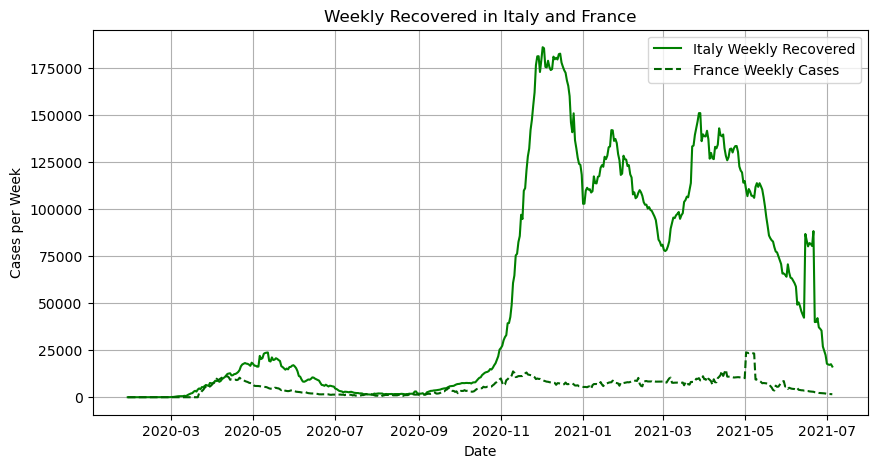

In [35]:
data_it_cut = data_it_cut.copy()
data_fr_cut = data_fr_cut.copy()
data_it_cut["weekly_recovered"] = data_it_cut["recovered"].diff(periods=7)
data_fr_cut["weekly_recovered"] = data_fr_cut["recovered"].diff(periods=7)

plt.figure(figsize=(10, 5))
plt.plot(data_it_cut.index, data_it_cut["weekly_recovered"], label="Italy Weekly Recovered", color="green")
plt.plot(data_fr_cut.index, data_fr_cut["weekly_recovered"], label="France Weekly Cases", color="darkgreen", linestyle="dashed")

plt.title("Weekly Recovered in Italy and France")
plt.xlabel("Date")
plt.ylabel("Cases per Week")
plt.legend()
plt.grid()
plt.show()

It can be observed that the graphs exhibit similar patterns. Special attention can be given to the "cases"-"recovered" ratio, as the latter represents the first shift by a few weeks. This can be explained by recalling that the time between becoming positive and recovering (returning to negative) typically takes a few weeks.


In general, the behaviors between France and Italy are comparable, except for the "recovered" variable.

In [ ]:
print(data_fr[data_fr["daily_cases"]<0])
#cfr grafico blu valori minori di zero